## Macro Forecasting of Asset price 

Important libraries and modules

In [493]:
import pandas as pd
import numpy as np 
import pandas_datareader as pdr
from scipy import stats
from scipy.stats import jarque_bera
import statsmodels.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import yfinance as yf

Seaborn ka use hamlog scatterplot aur Heatmap keliye kiye h 

# Importing Data 

In [4]:
start_date = datetime.datetime(2003,1,2)
end_date = datetime.datetime.today()

In [446]:
IR = pdr.get_data_fred('EFFR', start=start_date, end=end_date)
I = pdr.get_data_fred('T5YIE', start=start_date, end=end_date)
Gold = yf.download('GC=F',start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


Here:
EFFR  - Fed fund rate in real time what is happenign with bank in US each day
T5YIE - It gives the Inflation expectaion : Treasury yeaild - Treasury yeild adjusted with Inflation 
so you will get inflation expectation

# Plotting DataFrame

In [455]:
%%capture
fig, ax = plt.subplots(3, 1, figsize=(10, 18))
ax[0].plot(IR.dropna(), c='blue', label="Interest rate")
ax[1].plot(Gold['Close'].dropna(), c='yellow', label="Gold")
ax[2].plot(I.dropna(), c='red', label="Inflation")

# Refining Data

In [365]:
def fill_nan_with_surrounding_mean(df, column_name):
    nan_labels = df.index[df[column_name].isna()].tolist()
    for label in nan_labels:
        
        pos = df.index.get_loc(label)
        window_start = max(0, pos - 1)
        window_end = min(len(df) - 1, pos + 1)
        window_values = df[column_name].iloc[window_start : window_end + 1]
        window_values = window_values.drop(label, errors='ignore')
        mean_val = window_values.mean()
        df.at[label, column_name] = mean_val

In [387]:
fill_nan_with_surrounding_mean(df, 'Low')

1. For IR totalnull = 217
2. For I totalnull = 217
3. ->Both filled with its 5 backward and 5 forward avg value from the above function
4. IR and I have total 5804 value and Gold have only 5583 value so that many Nan value occur after merging -> we remove using 1 backward and 1 forward avg value of Gold
   

# Merging DataFrame

In [107]:
df1 = pd.merge(Gold,IR , on = 'DATE', how = 'outer')
df = pd.merge(df1,I , on = 'DATE', how = 'outer')

# Na rows to fill row 

In [ ]:
null = df.isna().any(axis=1)

In [472]:
%%capture
for i in null.index :
    cur = df.index.get_loc(i)
    print(df.iloc[cur-1:cur+2])

In [419]:
df = df.rename(columns={'EFFR':'IR','T5YIE':'Inflation'})

In [478]:
df.isnull().sum();

<Axes: xlabel='DATE'>

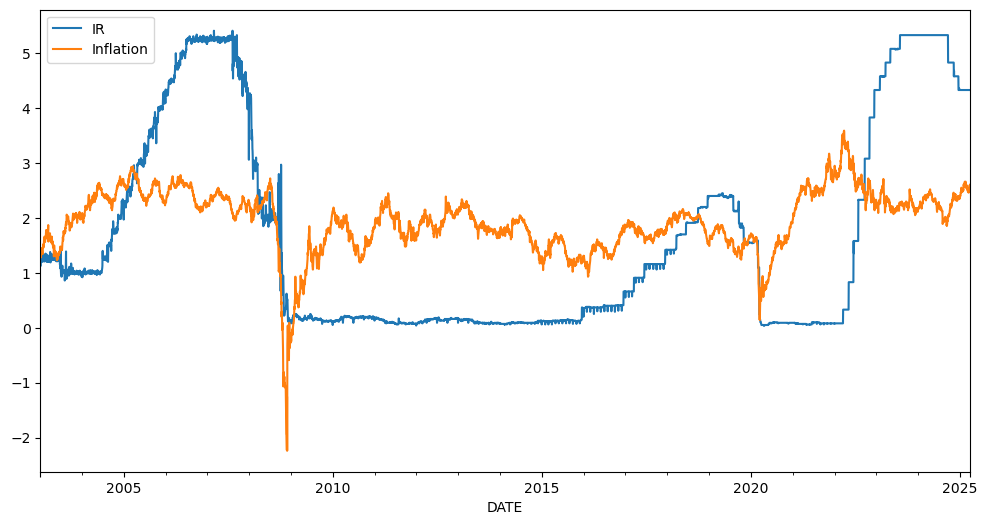

In [484]:
df[['IR','Inflation']].plot(figsize = (12,6))

# Correlation

1. Check kro data normal distributed h ya non normal distributed h through - Jarque bera 
2. Agr non normal h to Spearman test se correlation dekho 
3. Agr data normal distributed h to Pearson se correlation check kro 

In [486]:
df[['IR','Inflation']].corr()

,IR,Inflation
IR,1.00000,0.42469
Inflation,0.42469,1.00000


In [513]:
Ir = jarque_bera(df['IR'])
I = jarque_bera(df['Inflation'])
Gold = jarque_bera(df['Close'])
print(Ir.pvalue)
print(I.pvalue)
print(Gold.pvalue)

1.0217268833222834e-199
0.0
6.7895318877606094e-15


1. pvalue<0.05 means non-normal : Hypothesis not rejected
2. so dono keliye spearman lgana pdega

In [515]:
df[['IR','Inflation','Close']].corr(method = 'spearman')

,IR,Inflation,Close
IR,1.000000,0.401837,-0.172344
Inflation,0.401837,1.000000,0.073625
Close,-0.172344,0.073625,1.000000


In [521]:
df[['IR','Close','Inflation']].describe();

# Model Building 

ADFuller Test for Stationary data 

In [551]:
from statsmodels.tsa.stattools import adfuller

In [608]:
def sol(column):
    x= adfuller(column)[1]
    if x > 0.05:
        print('pvalue = ',x,'  -  Data is Not Stationary')
    else :
        print('pvalue = ',x,'  -  Data is Stationary')

In [621]:
sol(df['IR1'].dropna())

pvalue =  9.738665793967262e-14   -  Data is Stationary


So D = 1 

In [614]:
df['IR1'] = df['IR'] - df['IR'].shift(1)

In [626]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

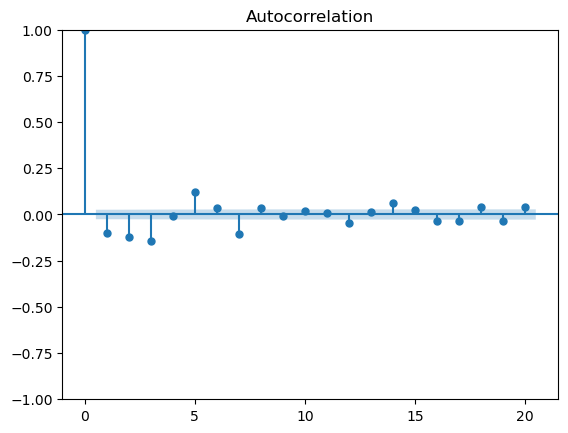

In [659]:
plot_acf(df['IR1'].dropna(),lags = 20);

Q = 1,2,3,5,7

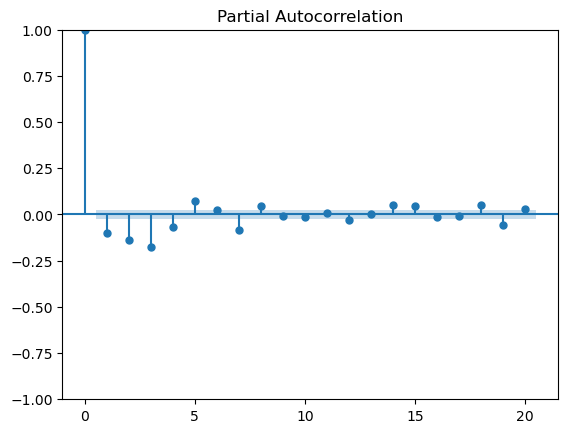

In [666]:
plot_pacf(df['IR1'].dropna(),lags=20);

P = 1,2,3,4,5,7,8